# **ライブラリのインストール**

In [1]:
!pip install tensorflow tensorflow_hub

# **Google Driveのマウント**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **■1.4 ImageDataGeneratorの動作確認**

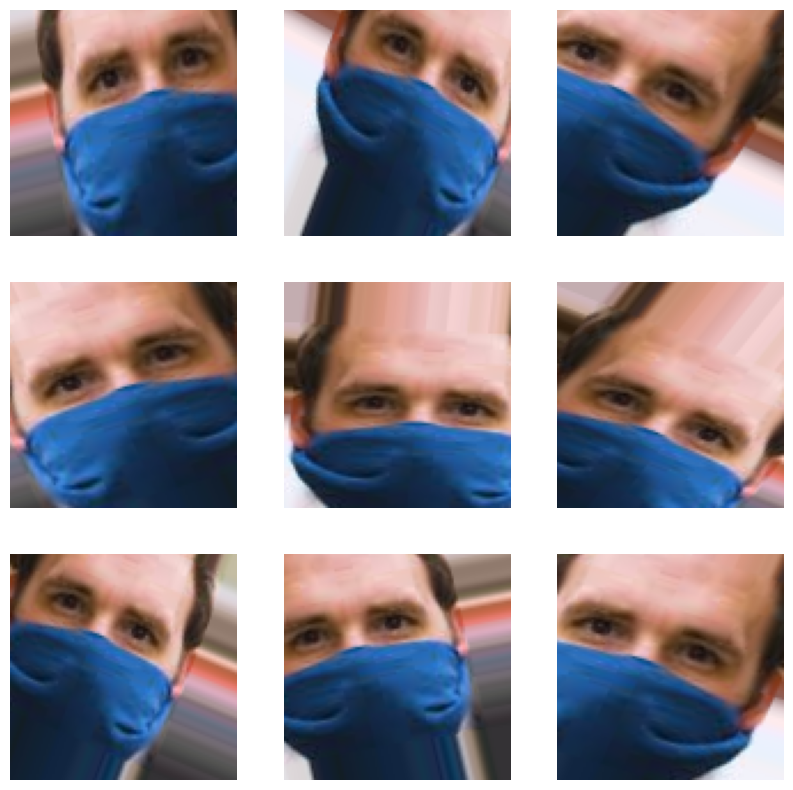

In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 画像のロード
image_path = '/content/drive/MyDrive/Face Mask Dataset/Train/WithMask/1077.png' # 画像のパスを指定
image = load_img(image_path)
image_array = img_to_array(image)
image_array = image_array.reshape((1,) + image_array.shape) # ImageDataGeneratorに合う形状に変換

# ImageDataGeneratorの設定
datagen = ImageDataGenerator(
    rescale=1./255,         # ピクセル値が0から1の範囲にスケール
    rotation_range=40,      # 40度の範囲でランダムに回転
    width_shift_range=0.2,  # 幅に対する0.2の割合でランダムに水平移動
    height_shift_range=0.2, # 高さに対する0.2の割合でランダムに垂直移動
    shear_range=0.2,        # シアー強度（反時計回りのシアー角度）
    zoom_range=0.2,         # ランダムにズーム
    horizontal_flip=True,   # 水平方向にランダムに反転
    fill_mode='nearest'     # 入力画像の境界周りを埋めるために使用するピクセルの埋め方
)

# 画像の拡張と表示
fig = plt.figure(figsize=(10, 10))
for i, batch in enumerate(datagen.flow(image_array, batch_size=1)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(batch[0])
    plt.axis('off')

    # 9枚の画像を生成して表示
    if i == 8:
        break

plt.show()

# **■ステップ2 : 学習用画像データの前処理**

## **■2.1 データのパス設定**

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 学習用データと検証用データのディレクトリパスを指定
train_dir = '/content/drive/MyDrive/Face Mask Dataset/Train'
valid_dir = '/content/drive/MyDrive/Face Mask Dataset/Validation'

## **■2.2 画像サイズとバッチサイズを設定**

In [6]:
# 画像のサイズとバッチサイズを設定
IMG_SIZE = 224
BATCH_SIZE = 32

## **2.3 データ前処理を行うためのImageDataGeneratorインスタンスを生成**

In [7]:
# 画像のピクセル値を0-1の範囲にスケールするためのデータジェネレータを設定
datagen = ImageDataGenerator(rescale=1./255)

## **■2.4 学習用データの読み込みと前処理**

In [8]:
# 学習用データの読み込みと前処理
train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # 画像のリサイズ
    batch_size=BATCH_SIZE,             # 1回のバッチで読み込む画像数
    class_mode='categorical'           # 分類タスクのためのラベル設定
)

Found 5480 images belonging to 2 classes.


## **■2.5 検証用データの読み込みと前処理**

In [9]:
# 検証用データの読み込みと前処理
valid_data = datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # 画像のリサイズ
    batch_size=BATCH_SIZE,             # 1回のバッチで読み込む画像数
    class_mode='categorical'           # 分類タスクのためのラベル設定
)

Found 800 images belonging to 2 classes.


# **■ステップ3 : モデル作成**

## **■3.1 CNNモデルの定義**

In [10]:
from tensorflow.keras import datasets, layers, models

# シーケンシャルモデルの作成
model = models.Sequential()

# 最初の畳み込み層：128個の3x3フィルター、ReLU活性化
# 画像の特徴を検出（例：エッジ、テクスチャなど）
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))

# 最大プーリング層：2x2のサイズで、画像のサイズを半分にする
model.add(layers.MaxPooling2D((2, 2)))

# 64個のフィルターで畳み込み
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# 再度最大プーリング
model.add(layers.MaxPooling2D((2, 2)))

# 64個のフィルターで畳み込み
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# 画像を1Dのベクトルに変換
model.add(layers.Flatten())

# 64ノードの全結合層、ReLU活性化
model.add(layers.Dense(64, activation='relu'))

# 出力層：2ノード、ソフトマックス活性化（2クラス分類）
model.add(layers.Dense(2, activation='softmax'))

## **■3.2 コンパイル**

In [11]:
# モデルのコンパイル（最適化アルゴリズム、損失関数、評価メトリックを設定）
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## **■3.3 学習**

In [ ]:
# モデルのトレーニング（トレーニングデータでフィッティングし、検証データで評価）
model.fit(train_data, epochs=3, validation_data=valid_data)

Epoch 1/3
 24/172 [===>..........................] - ETA: 1:12 - loss: 0.6539 - accuracy: 0.8516

 ## **■3.4 モデルの保存**

In [ ]:
model.save('mask_model.keras')